# Compute the full depth OMZ volume for tropics and Full Pacific

## Todo
- [ ]Extend to full globe when the cmip6_masking is ready

In [58]:
import intake
import pathlib
import xarray as xr
import matplotlib.pyplot as plt
import cf_xarray

import cartopy.crs as ccrs

from fastprogress import progress_bar
from cmip6_omz.boundaries import omz_boundaries
from cmip6_omz.utils import cmip6_collection, o2_models

from cmip6_preprocessing.utils import cmip6_dataset_id
from cmip6_preprocessing.drift_removal import match_and_remove_trend
from cmip6_preprocessing.preprocessing import combined_preprocessing
from cmip6_preprocessing.postprocessing import match_metrics

from xarrayutils.file_handling import write, maybe_create_folder
from xarrayutils.plotting import map_util_plot
from xarrayutils.utils import linear_trend

from distributed import LocalCluster, Client

from cmip6_omz.omz_tools import omz_thickness
from dask.diagnostics import ProgressBar
from cmip6_omz.omz_tools import mask_basin
from xhistogram.xarray import histogram
import numpy as np
from cmip6_omz.units import convert_mol_m3_mymol_kg
from fastprogress.fastprogress import progress_bar

In [2]:
# set up dask
mem_total = 400
workers = 4
threads = 5 # more threads work a looooot better for the trend calculation (less comms)
cluster = LocalCluster(
    memory_limit=f"{int(mem_total/workers)}GiB",
    dashboard_address=9999,
    threads_per_worker=threads,
    n_workers = workers,
                      )
client = Client(cluster)
client

distributed.diskutils - INFO - Found stale lock file and directory '/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/notebooks/processing/dask-worker-space/worker-z73pi8ti', purging
distributed.diskutils - INFO - Found stale lock file and directory '/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/notebooks/processing/dask-worker-space/worker-o7ux3e4k', purging
distributed.diskutils - INFO - Found stale lock file and directory '/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/notebooks/processing/dask-worker-space/worker-b9ypx4uo', purging
distributed.diskutils - INFO - Found stale lock file and directory '/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip6_omz/notebooks/processing/dask-worker-space/worker-6l542ehy', purging


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:9999/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:9999/status,Workers: 4
Total threads: 20,Total memory: 400.00 GiB
Comm: tcp://127.0.0.1:46146,Workers: 4
Dashboard: http://127.0.0.1:9999/status,Total threads: 20
Started: Just now,Total memory: 400.00 GiB
Comm: tcp://127.0.0.1:40148,Total threads: 5
Dashboard: http://127.0.0.1:35162/status,Memory: 100.00 GiB
Nanny: tcp://127.0.0.1:45556,


In [3]:
from cmip6_omz.upstream_stash import concat_members, concat_experiments

In [64]:
col.df['zstore'].tolist()[0]

'/projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/ScenarioMIP/CNRM-CERFACS/CNRM-ESM2-1/ssp245/r3i1p1f2/Ofx/areacello/gn/v20190410/ScenarioMIP.CNRM-CERFACS.CNRM-ESM2-1.ssp245.r3i1p1f2.Ofx.areacello.gn.v20190410.zarr'

In [4]:
col = intake.open_esm_datastore(cmip6_collection(zarr=True)) # Takes wayyy to long for now

kwargs = {
    "preprocess": combined_preprocessing,
    "cdf_kwargs": {"use_cftime": True, "chunks":{'time':3}, 'engine':'h5netcdf'},
    "zarr_kwargs": {'use_cftime': True, 'consolidated':True},
    "aggregate": False,
}

regress_vars = ['o2']
metric_vars = ['areacello', 'thkcello']
# models = ['GFDL-CM4', 'GFDL-ESM4']
models = o2_models()

cat = col.search(
    source_id=models,
    variable_id=regress_vars,
    experiment_id=['historical', 'ssp585']
)
ddict = cat.to_dataset_dict(**kwargs)

# metrics
cat_m = col.search(
    source_id=models,
    variable_id=metric_vars,
)
ddict_m = cat_m.to_dataset_dict(**kwargs)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')


/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/preprocessing.py:228: UserWarning: MIROC-ES2L: No units found for lev
  warnings.warn(f'{ds.attrs["source_id"]}: No units found for {co}')
/scratch/gpfs2/jbusecke/


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.version.zstore'


In [5]:
# somehow xarray cannot deal with comparing list/int attrs (Occurs in CM4)
# I should raise that, but lets fix it quickly here
def clean_attrs(ds):
    for a, attr in ds.attrs.items():
        if isinstance(attr, int):
            ds.attrs[a] = [attr]
    return ds

def maybe_chunk(ds):
#     if 'time' in ds.dims:
#         ds = ds.chunk({'time':1})
    
#     if 'lev' in ds.dims:
#         ds = ds.chunk({'lev':35})

    return ds

ddict = {k:maybe_chunk(clean_attrs(ds)) for k,ds in ddict.items()}
ddict_m = {k:maybe_chunk(clean_attrs(ds)) for k,ds in ddict_m.items()}

In [6]:
ddict = match_metrics(ddict, ddict_m, metric_vars)

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:545: UserWarning: No matching metrics found for areacello
  warnings.warn(f"No matching metrics found for {mv}")
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:545: UserWarning: No matching metrics found for thkcello
  warnings.warn(f"No matching metrics found for {mv}")
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:566: UserWarning: This metric had a time dimension and did not perfectly match. Not parsing anything.
  warnings.warn(


In [7]:
# Detrend
flist = list(pathlib.Path('../../data/external/cmip6_control_drifts/').absolute().glob('*.nc'))
trend_dict = {}
for f in progress_bar(flist):
    trend_dict[f.stem] = xr.open_mfdataset([f])

# detrend
ddict_detrended = match_and_remove_trend(
    ddict,
    trend_dict,
    check_mask=False # should be deactivated once the trends are completed (i have a few in there now that dont have a nanmask applied)
)

/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r21i1p1f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.CCCma.CanESM5.historical.r20i1p1f1.Omon.gn.v20190429
  warnings.warn(nomatch_msg)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.NCC.NorCPM1.historical.r30i1p1f1.Omon.gr.none
  warnings.warn(nomatch_msg)
/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/cmip6_preprocessing/postprocessing.py:60: UserWarning: Could not find a matching dataset for CMIP.MPI-M.MPI-ESM1-2-HR.historica

In [29]:
[k for k in ddict_detrended.keys() if 'ACCESS' in k and 'r2i1p1f1' in k]

['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1.Omon.o2.gn.v20191129./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r2i1p1f1/Omon/o2/gn/v20191129/ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1.Omon.o2.gn.v20191129.zarr',
 'CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omon.o2.gn.v20191128./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r2i1p1f1/Omon/o2/gn/v20191128/CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omon.o2.gn.v20191128.zarr']

In [30]:
# manually check ACCESS
ds = ddict_detrended['CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omon.o2.gn.v20191128./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/historical/r2i1p1f1/Omon/o2/gn/v20191128/CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omon.o2.gn.v20191128.zarr']
ds_f = ddict_detrended['ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1.Omon.o2.gn.v20191129./projects/GEOCLIM/LRGROUP/jbusecke/projects/cmip_data_management_princeton/builder/../zarr_conversion/CMIP6/ScenarioMIP/CSIRO/ACCESS-ESM1-5/ssp585/r2i1p1f1/Omon/o2/gn/v20191129/ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1.Omon.o2.gn.v20191129.zarr']

In [34]:
ds

<xarray.Dataset>
Dimensions:        (x: 360, y: 300, vertex: 4, lev: 50, bnds: 2, time: 1980)
Coordinates: (12/15)
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    lat            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
  * lev            (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    ...             ...
    time_bounds    (time, bnds) object dask.array<chunksize=(3, 2), meta=np.ndarray>
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    areacello      (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
Data variables:
    o2             (time, lev, y, x) float64 dask.array<chunksize=(3, 50, 300, 360), meta=np.ndarray>
Attributes: (12/50)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             CMIP
    branch_method:           standard
    branch_time_in_child:    [0.0]
    branch_time_in_parent:   [29220.0]
    cmor_version:            3.4.0
    ...                      ...
    variable_id:             o2
    variant_label:           r2i1p1f1
    version:                 v20191128
    intake_esm_varname:      None
    intake_esm_dataset_key:  CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omo...
    original_key:            CMIP.CSIRO.ACCESS-ESM1-5.historical.r2i1p1f1.Omo...

In [35]:
ds_f

<xarray.Dataset>
Dimensions:        (x: 360, y: 300, vertex: 4, lev: 50, bnds: 2, time: 1032)
Coordinates: (12/16)
  * x              (x) int32 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * y              (y) int32 0 1 2 3 4 5 6 7 ... 292 293 294 295 296 297 298 299
    lat            (y, x) float64 dask.array<chunksize=(300, 360), meta=np.ndarray>
    lat_verticies  (y, x, vertex) float64 dask.array<chunksize=(300, 360, 4), meta=np.ndarray>
  * lev            (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
    lev_bounds     (lev, bnds) float64 dask.array<chunksize=(50, 2), meta=np.ndarray>
    ...             ...
  * vertex         (vertex) int64 0 1 2 3
  * bnds           (bnds) int64 0 1
    lon_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    lat_bounds     (bnds, y, x) float64 dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
    areacello      (y, x) float32 dask.array<chunksize=(300, 360), meta=np.ndarray>
    thkcello       (time, lev, y, x) float32 dask.array<chunksize=(3, 50, 300, 360), meta=np.ndarray>
Data variables:
    o2             (time, lev, y, x) float64 dask.array<chunksize=(3, 50, 300, 360), meta=np.ndarray>
Attributes: (12/49)
    Conventions:             CF-1.7 CMIP-6.2
    activity_id:             ScenarioMIP
    branch_method:           standard
    branch_time_in_child:    [60265.0]
    branch_time_in_parent:   [60265.0]
    cmor_version:            3.4.0
    ...                      ...
    tracking_id:             hdl:21.14100/cbd75f16-a6ee-4bd9-bb24-98bb21b586de
    variable_id:             o2
    variant_label:           r2i1p1f1
    version:                 v20191129
    intake_esm_varname:      None
    intake_esm_dataset_key:  ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r2i1p1f1....

In [33]:
xr.concat([ds, ds_f], 'time', coords='minimal')#**{'combine_attrs': 'drop_conflicts', 'compat': 'override', 'coords': 'minimal'}

ValueError: Variables {'thkcello'} are coordinates in some datasets but not others.

In [37]:
# somehow the historical runs have a dz for access but the ssp runs dont...
# Let me fix that manually for now
fix_keys = [k for k in ddict_detrended.keys() if 'ACCESS' in k]
for k in fix_keys:
    ds = ddict_detrended[k]
    if 'thkcello' in ds.variables:
        ds = ds.drop('thkcello')
    ddict_detrended[k] = ds

In [39]:
# Combine and filter
ddict_full_run = concat_experiments(ddict_detrended)
# filter out the ones that dont have the full time range
ddict_full_run = {k:ds for k,ds in ddict_full_run.items() if len(ds.time) > 3000}
for name, ds in ddict_full_run.items():
    print(f"{name} {len(ds.time)}")

MPI-ESM1-2-LR.gn.Omon.r8i1p1f1 3012
IPSL-CM6A-LR.gn.Omon.r14i1p1f1 3012
UKESM1-0-LL.gn.Omon.r1i1p1f2 3012
CanESM5.gn.Omon.r9i1p2f1 3012
MPI-ESM1-2-LR.gn.Omon.r3i1p1f1 3012
CanESM5.gn.Omon.r1i1p1f1 5412
UKESM1-0-LL.gn.Omon.r4i1p1f2 3012
MPI-ESM1-2-LR.gn.Omon.r6i1p1f1 3012
CanESM5-CanOE.gn.Omon.r3i1p2f1 3012
CanESM5.gn.Omon.r7i1p2f1 3012
NorESM2-MM.gr.Omon.r1i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r1i1p1f1 3012
IPSL-CM6A-LR.gn.Omon.r3i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r4i1p1f1 3012
CanESM5.gn.Omon.r4i1p1f1 3012
CanESM5.gn.Omon.r1i1p2f1 3012
CanESM5.gn.Omon.r9i1p1f1 3012
UKESM1-0-LL.gn.Omon.r8i1p1f2 3012
CanESM5.gn.Omon.r2i1p1f1 3012
CanESM5.gn.Omon.r5i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r5i1p1f1 3012
CanESM5.gn.Omon.r10i1p2f1 3012
CanESM5.gn.Omon.r8i1p1f1 3012
ACCESS-ESM1-5.gn.Omon.r1i1p1f1 3012
IPSL-CM6A-LR.gn.Omon.r2i1p1f1 3012
CNRM-ESM2-1.gn.Omon.r4i1p1f2 3012
NorESM2-LM.gr.Omon.r1i1p1f1 3012
MPI-ESM1-2-LR.gn.Omon.r9i1p1f1 3012
ACCESS-ESM1-5.gn.Omon.r2i1p1f1 3012
CNRM-ESM2-1.gn.Omon.r2i1p1f2 30

I am loosing ACCESS here, and that is only since today? WTF is wrong with this?

In [40]:
ddict_final = ddict_full_run

In [41]:
from cmip6_preprocessing.grids import combine_staggered_grid
problems = {'missing_variables':[], 'missing_area':[], 'missing_thickness':[], 'reconstructed_area':[], 'reconstructed_thickness':[]}
ddict_filtered = {}
for name, ds in ddict_final.items():
    flag = False
    # Check that all necessary variables are given
    missing_variables = [va for va in ["o2"] if va not in ds.variables]
    if len(missing_variables)>0:
        flag = True
        problems['missing_variables'].append((name, missing_variables))
        
    # Check for area
    if not 'areacello' in ds.coords:
        if ds.attrs['grid_label'] == 'gr': # only reconstruct for regular grids
            grid, ds = combine_staggered_grid(ds, recalculate_metrics=True)
            # I am dropping dz_t here so it can be uniformly reconstructed
            ds = ds.drop('dz_t')
            ds['areacello'] = ds.dx_t * ds.dy_t
            problems['reconstructed_area'].append(name)
        else:
            flag = True
            problems['missing_area'].append(name)
    
    # Check for thickness (and rename) TODO: We should probably not rename and just refactor to use `thkcello`
    if not "thkcello" in ds.coords:
        # try to reconstruct the thickness from static info
        try:
            lev_vertices = cf_xarray.bounds_to_vertices(ds.lev_bounds, 'bnds').load()
            dz_t = lev_vertices.diff('lev_vertices')
            ds = ds.assign_coords(thkcello=('lev', dz_t.data))
            problems['reconstructed_thickness'].append(name)
        except Exception as e:
            print(f'{name} thickness reconstruction failed with {e}')
            print(ds)
            problems['missing_thickness'].append(name)
            flag=True
            
    if not flag:
        ddict_filtered[name] = ds

In [42]:
problems

{'missing_variables': [],
 'missing_area': [],
 'missing_thickness': [],
 'reconstructed_area': ['NorESM2-MM.gr.Omon.r1i1p1f1',
  'NorESM2-LM.gr.Omon.r1i1p1f1'],
 'reconstructed_thickness': ['ACCESS-ESM1-5.gn.Omon.r1i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r2i1p1f1',
  'ACCESS-ESM1-5.gn.Omon.r3i1p1f1',
  'MRI-ESM2-0.gn.Omon.r1i2p1f1',
  'MIROC-ES2L.gn.Omon.r1i1p1f2',
  'GFDL-ESM4.gr.Omon.r1i1p1f1',
  'GFDL-CM4.gr.Omon.r1i1p1f1']}

In [43]:
list(np.sort(list(ddict_filtered.keys())))

['ACCESS-ESM1-5.gn.Omon.r1i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r2i1p1f1',
 'ACCESS-ESM1-5.gn.Omon.r3i1p1f1',
 'CNRM-ESM2-1.gn.Omon.r1i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r2i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r3i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r4i1p1f2',
 'CNRM-ESM2-1.gn.Omon.r5i1p1f2',
 'CanESM5-CanOE.gn.Omon.r1i1p2f1',
 'CanESM5-CanOE.gn.Omon.r2i1p2f1',
 'CanESM5-CanOE.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r10i1p1f1',
 'CanESM5.gn.Omon.r10i1p2f1',
 'CanESM5.gn.Omon.r1i1p1f1',
 'CanESM5.gn.Omon.r1i1p2f1',
 'CanESM5.gn.Omon.r2i1p1f1',
 'CanESM5.gn.Omon.r2i1p2f1',
 'CanESM5.gn.Omon.r3i1p1f1',
 'CanESM5.gn.Omon.r3i1p2f1',
 'CanESM5.gn.Omon.r4i1p1f1',
 'CanESM5.gn.Omon.r4i1p2f1',
 'CanESM5.gn.Omon.r5i1p1f1',
 'CanESM5.gn.Omon.r5i1p2f1',
 'CanESM5.gn.Omon.r6i1p1f1',
 'CanESM5.gn.Omon.r6i1p2f1',
 'CanESM5.gn.Omon.r7i1p1f1',
 'CanESM5.gn.Omon.r7i1p2f1',
 'CanESM5.gn.Omon.r8i1p1f1',
 'CanESM5.gn.Omon.r8i1p2f1',
 'CanESM5.gn.Omon.r9i1p1f1',
 'CanESM5.gn.Omon.r9i1p2f1',
 'GFDL-CM4.gr.Omon.r1i1p1f1',
 'GFDL-ESM4.g

In [44]:
%matplotlib inline

--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r8i1p1f1
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r14i1p1f1
--------------------------------------
UKESM1-0-LL.gn.Omon.r1i1p1f2
--------------------------------------
CanESM5.gn.Omon.r9i1p2f1
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r3i1p1f1
--------------------------------------
CanESM5.gn.Omon.r1i1p1f1
--------------------------------------
UKESM1-0-LL.gn.Omon.r4i1p1f2
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r6i1p1f1
--------------------------------------
CanESM5-CanOE.gn.Omon.r3i1p2f1
--------------------------------------
CanESM5.gn.Omon.r7i1p2f1
--------------------------------------
NorESM2-MM.gr.Omon.r1i1p1f1
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r1i1p1f1
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r3i1p1f1
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r4i1p1f1
--------------------------------------
CanESM5

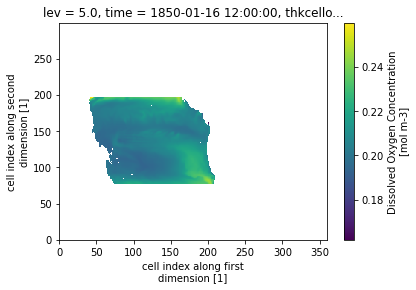

$ Saving 0.018097432GB to ../../data/processed/full_volume_pac/none.CSIRO.ACCESS-ESM1-5.none.r1i1p1f1.Omon.gn.v20191115_r1i1p1f1.zarr
$ Reloading file
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r2i1p1f1
--------------------------------------
CNRM-ESM2-1.gn.Omon.r4i1p1f2
--------------------------------------
NorESM2-LM.gr.Omon.r1i1p1f1
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r9i1p1f1
--------------------------------------
ACCESS-ESM1-5.gn.Omon.r2i1p1f1


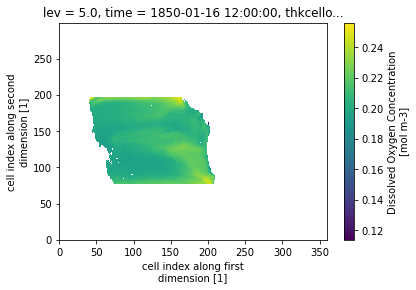

$ Saving 0.018097432GB to ../../data/processed/full_volume_pac/none.CSIRO.ACCESS-ESM1-5.none.r2i1p1f1.Omon.gn.none_r2i1p1f1.zarr
$ Reloading file
--------------------------------------
CNRM-ESM2-1.gn.Omon.r2i1p1f2
--------------------------------------
UKESM1-0-LL.gn.Omon.r2i1p1f2
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r1i1p1f1
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r4i1p1f1
--------------------------------------
ACCESS-ESM1-5.gn.Omon.r3i1p1f1


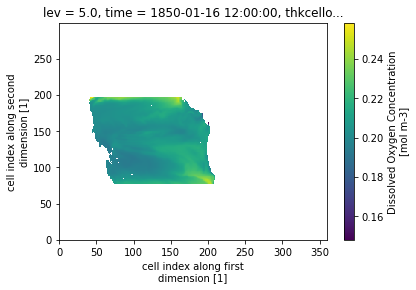

$ Saving 0.018097432GB to ../../data/processed/full_volume_pac/none.CSIRO.ACCESS-ESM1-5.none.r3i1p1f1.Omon.gn.v20191203_r3i1p1f1.zarr
$ Reloading file
--------------------------------------
CanESM5.gn.Omon.r6i1p2f1
--------------------------------------
CanESM5.gn.Omon.r3i1p2f1
--------------------------------------
CNRM-ESM2-1.gn.Omon.r3i1p1f2
--------------------------------------
MPI-ESM1-2-HR.gn.Omon.r1i1p1f1
--------------------------------------
CNRM-ESM2-1.gn.Omon.r5i1p1f2
--------------------------------------
UKESM1-0-LL.gn.Omon.r3i1p1f2
--------------------------------------
CanESM5.gn.Omon.r8i1p2f1
--------------------------------------
MPI-ESM1-2-LR.gn.Omon.r7i1p1f1
--------------------------------------
CanESM5-CanOE.gn.Omon.r1i1p2f1
--------------------------------------
CanESM5.gn.Omon.r10i1p1f1
--------------------------------------
CanESM5.gn.Omon.r7i1p1f1
--------------------------------------
IPSL-CM6A-LR.gn.Omon.r6i1p1f1
--------------------------------------
MPI-ES

In [57]:
ofolder = maybe_create_folder(f"../../data/processed/full_volume_pac")
bins = np.arange(-20, 140, 10)
bins_converted = bins / convert_mol_m3_mymol_kg(xr.DataArray([1])).data
overwrite = True

ddict_in = ddict_filtered
results = {}
for name, ds_in in progress_bar(ddict_in.items()):
    print("--------------------------------------")
    print(name)
#     print(ds_in.lev_bounds)
    if not 'ACCESS' in name:
        continue
    else:

        dataset_id = f"{cmip6_dataset_id(ds_in)}_{ds_in.attrs['variant_label']}"
        filename = ofolder.joinpath(f"{dataset_id}.zarr")

        ds_in["vol"] = ds_in.thkcello * ds_in.areacello

        attrs = ds_in.attrs

        if filename.exists() and not overwrite:
            omz_vol_integrated_reloaded = xr.open_zarr(filename, consolidated=True)
        else:

            # I think this is still super not helpful for the performance...
            # TODO: Use the basin groupby "trick" from the watermass project
            ds_masked = ds_in.where(abs(ds_in.lat) <= 30, drop=False)
            ds_masked = mask_basin(ds_masked, drop=False)

            plt.figure()
            ds_masked.o2.isel(time=0, lev=0).plot()
            plt.show()

            # replace this with groupby basins later
            hist = histogram(
                ds_masked.o2, bins=bins_converted, dim=["x", "y"], weights=ds_masked.vol
            )
            hist = hist.load()

            hist = hist.to_dataset(name="omz_volume")
            hist.attrs = {
                k: v for k, v in attrs.items() if k not in ["intake_esm_varname"]
            }

            # replace bins with upper bin boundary
            hist = hist.assign_coords(o2_bin=bins[1:])
            hist.o2_bin.attrs["units"] = "\mu mol/kg"
            
            # add lev bounds so I am able to reconstruct static cell thickness
            hist = hist.assign_coords(lev_bounds=ds.lev_bounds.reset_coords(drop=True).load())
            
            assert all([di not in hist.dims for di in ['x','y']])

            omz_vol_integrated_reloaded = write(
                hist,
                filename,
                overwrite=overwrite,
                check_zarr_complete=True,
                consolidated=True,
                write_kwargs=dict(safe_chunks=False)
            )

        results[name] = omz_vol_integrated_reloaded

In [52]:
hist = hist.assign_coords(lev_bounds=ds.lev_bounds.reset_coords(drop=True).load())
hist

<xarray.Dataset>
Dimensions:     (time: 3012, lev: 50, o2_bin: 15, bnds: 2)
Coordinates:
  * time        (time) object 1850-01-16 12:00:00 ... 2100-12-16 12:00:00
  * lev         (lev) float64 5.0 15.0 25.0 ... 5.166e+03 5.499e+03 5.831e+03
  * o2_bin      (o2_bin) int64 -10 0 10 20 30 40 50 60 70 80 90 100 110 120 130
    thkcello    (lev) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    dz          (lev) float64 10.0 10.0 10.0 10.0 ... 322.1 328.3 332.6 334.7
  * bnds        (bnds) int64 0 1
    lev_bounds  (lev, bnds) float64 nan nan nan nan nan ... nan nan nan nan nan
Data variables:
    omz_volume  (time, lev, o2_bin) float64 0.0 0.0 0.0 ... 0.0 1.736e+14 0.0
Attributes: (12/36)
    Conventions:           CF-1.7 CMIP-6.2
    branch_method:         standard
    cmor_version:          3.4.0
    data_specs_version:    01.00.30
    external_variables:    areacello volcello
    forcing_index:         [1]
    ...                    ...
    table_info:            Creation Date:(30 April 2019) MD5:e14f55f257cceafb...
    title:                 ACCESS-ESM1-5 output prepared for CMIP6
    variable_id:           o2
    variant_label:         r1i1p1f1
    version:               v20191115
    original_key:          ScenarioMIP.CSIRO.ACCESS-ESM1-5.ssp585.r1i1p1f1.Om...

In [24]:
def convert_to_cumulative_volume(hist):
    # why on earth would this remove the coordinates?
    hist_cumu = hist.cumsum("o2_bin")
    hist_cumu = hist_cumu.assign_coords(o2_bin=hist.o2_bin)
    return hist_cumu

In [25]:
plt.figure()
for name, ds in results.items():
    vol = convert_to_cumulative_volume(ds).omz_volume.sel(o2_bin=80).sum('lev')
    vol.plot()

TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2ae4f9c53c10> (for post_execute):


TypeError: tzinfo argument must be None or of a tzinfo subclass, not type 'numpy.str_'

In [22]:
plt.figure()
for name, ds in results.items():
    ds_hist = convert_to_cumulative_volume(ds).omz_volume.sel(time=slice('1850', '1900')).mean('time')
    ds_ssp = convert_to_cumulative_volume(ds).omz_volume.sel(time=slice('2050', '2100')).mean('time')

    ((ds_ssp - ds_hist)/ds.dz).sel(o2_bin=80).plot(y='lev', yincrease=False)

Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/distributed/nanny.py", line 830, in _run
    loop.run_sync(run)
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/tornado/ioloop.py", line 524, in run_sync
    self.start()
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
    self._run_once()
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/asyncio/base_events.py", line 1854, in _run_once
    event_list = self._selector.select(timeout)
  File "/scratch/gpfs2/jbusecke/conda_tigressdata/envs/cmip6_omz/lib/python3.9/selectors.py", line 469, in sel

KeyboardInterrupt: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x2ae4f9c53c10> (for post_execute):


ConversionError: Failed to convert value(s) to axis units: 'lev'

distributed.nanny - WARNING - Restarting worker


## Next steps
- [ ]Better basin separation
- Conserve more dimensions? Like integrate over lev only? (That would eliminate the need for seperate masking, but also require lots of data)